In [60]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import img_as_float

In [61]:
# Imports for k-means initialization, EM is mostly implemented from scratch
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

**Functions for Expectation Maximization**

In [62]:
def getNormalProbability(x, mean, covariance):
    # Computes the probability of a point under a multivariate Gaussian

    D = len(x)
    det_covariance = np.linalg.det(covariance)
    inv_covariance = np.linalg.inv(covariance)

    norm_term = 1/(np.sqrt(np.power(2 * np.pi, x.shape[0]) * det_covariance))
    exp_term = np.exp(-0.5 * np.dot(np.dot((x - mean).T, inv_covariance), (x - mean)))

    return norm_term * exp_term

In [63]:
def getLogLikelihood(means, weights, covariances, X):
    # Log Likelihood estimation
    #
    # INPUT:
    # means          : Mean for each Gaussian KxD
    # weights        : Weight vector 1xK for K Gaussians
    # covariances    : Covariance matrices for each gaussian DxDxK
    # X              : Input data NxD
    # where N is number of data points
    # D is the dimension of the data points
    # K is number of gaussians
    #
    # OUTPUT:
    # logLikelihood  : log-likelihood

    N = X.shape[0]
    D = X.shape[1]
    K = len(weights)
    logLikelihood = 0

    for n in range(N):
        logLikelihood_n = 0
        for k in range(K):
          weight_k = weights[k]
          mean_k = means[k]
          covariance_k = covariances[:,:,k]
          logLikelihood_n += weight_k * getNormalProbability(X[n], mean_k, covariance_k)
        logLikelihood += np.log(logLikelihood_n)
    return logLikelihood

In [64]:
def EStep(means, covariances, weights, X):
    # Expectation step of the EM Algorithm
    #
    # INPUT:
    # means          : Mean for each Gaussian KxD
    # weights        : Weight vector 1xK for K Gaussians
    # covariances    : Covariance matrices for each Gaussian DxDxK
    # X              : Input data NxD
    #
    # N is number of data points
    # D is the dimension of the data points
    # K is number of Gaussians
    #
    # OUTPUT:
    # logLikelihood  : Log-likelihood (a scalar).
    # gamma          : NxK matrix of responsibilities for N datapoints and K Gaussians.

    N = X.shape[0]
    D = X.shape[1]
    K = len(weights)
    logLikelihood = getLogLikelihood(means, weights, covariances, X)

    gamma = np.zeros((N, K))
    for n in range(N):
      denominator = 0
      gamma_n = np.zeros(K)
      for k in range(K):
        weight_k = weights[k]
        mean_k = means[k]
        covariance_k = covariances[:,:,k]
        denominator += weight_k * getNormalProbability(X[n], mean_k, covariance_k)
        gamma_n[k] = weight_k * getNormalProbability(X[n], mean_k, covariance_k)
      gamma[n] = gamma_n / denominator

    return [logLikelihood, gamma]


In [65]:
def MStep(gamma, X):
    # Maximization step of the EM Algorithm
    #
    # INPUT:
    # gamma          : NxK matrix of responsibilities for N datapoints and K Gaussians.
    # X              : Input data (NxD matrix for N datapoints of dimension D).
    #
    # N is number of data points
    # D is the dimension of the data points
    # K is number of Gaussians
    #
    # OUTPUT:
    # logLikelihood  : Log-likelihood (a scalar).
    # means          : Mean for each gaussian (KxD).
    # weights        : Vector of weights of each gaussian (1xK).
    # covariances    : Covariance matrices for each component(DxDxK).

    N = X.shape[0]
    D = X.shape[1]
    K = gamma.shape[1]

    means = np.zeros((K, D))
    weights = np.zeros(K)
    covariances = np.zeros((D, D, K))

    for k in range(K):
      gamma_k = gamma[:,k]
      N_k = np.sum(gamma_k)
      weights[k] = N_k / N
      means[k] = np.dot(gamma_k, X) / N_k
      covariances[:,:,k] = np.dot(gamma_k * (X - means[k]).T, (X - means[k])) / N_k

    logLikelihood = getLogLikelihood(means, weights, covariances, X)
    return weights, means, covariances, logLikelihood

In [66]:
def regularize_cov(covariance, epsilon):
    # regularize a covariance matrix, by enforcing a minimum
    # value on its singular values. Explanation see exercise sheet.
    #
    # INPUT:
    #  covariance: matrix
    #  epsilon:    minimum value for singular values
    #
    # OUTPUT:
    # regularized_cov: reconstructed matrix

    regularized_cov = covariance + epsilon * np.eye(covariance.shape[0])
    return regularized_cov

In [67]:
def estGaussMixEM(data, K, n_iters, epsilon):
    # EM algorithm for estimation gaussian mixture mode
    #
    # INPUT:
    # data           : input data, N observations, D dimensional
    # K              : number of mixture components (modes)
    #
    # OUTPUT:
    # weights        : mixture weights - P(j) from lecture
    # means          : means of gaussians
    # covariances    : covariancesariance matrices of gaussians
    # logLikelihood  : log-likelihood of the data given the model

    weights=np.ones(K)/K

    kmeans = KMeans(n_clusters=K, n_init=10).fit(data)
    cluster_idx = kmeans.labels_
    means = kmeans.cluster_centers_

    # Create initial covariance matrices
    covariances = np.zeros((data.shape[1], data.shape[1], K))

    for j in range(K):
      data_cluster = data[cluster_idx == j]
      min_dist = np.inf

      for i in range(K):
          # Compute the mean squared distance in the cluster
          dist = np.mean(euclidean_distances(data_cluster, [means[i]], squared=True))
          if dist < min_dist:
              min_dist = dist
      covariances[:, :, j] = np.eye(data.shape[1]) * min_dist

    for iter in range(n_iters):
      logLikelihood, gamma = EStep(means, covariances, weights, data)
      weights, means, covariances, logLikelihood = MStep(gamma, data)
      reg_covariances = np.zeros(covariances.shape)
      for k in range(K):
        reg_covariances[:,:,k] = regularize_cov(covariances[:,:,k], epsilon)
      covariances = reg_covariances

    return [weights, means, covariances]

**Some Helper Functions**

In [68]:
def plotGaussian(mu, sigma):
    dimension = mu.shape[0]
    if len(mu.shape) > 1:
        n_components = mu.shape[1]
    else:
        n_components = 1
    plt.subplot()
    if dimension == 2:
        if n_components == 1 and sigma.shape == (2, 2):
            n = 36
            phi = np.arange(0, n, 1) / (n-1) * 2 * np.pi
            epoints = np.sqrt(np.abs(sigma)).dot([np.cos(phi), np.sin(phi)]) + mu[:, np.newaxis]
            plt.plot(epoints[0, :], epoints[1, :], 'r')
        else:
            print('ERROR: size mismatch in mu or sigma\n')
    else:
        raise ValueError('Only dimension 2 is implemented.')

In [69]:
def plotModes(means, covMats, X):
    plt.subplot()
    plt.scatter(X[:, 0], X[:, 1])
    M = means.shape[1]

    for i in range(M):
        plotGaussian(means[:, i], covMats[:, :, i])

In [70]:
def im2double(im):
    min_val = np.min(im.ravel())
    max_val = np.max(im.ravel())
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

**Parameters**

In [71]:
def parameters():
    epsilon = 0.0001 # regularization
    K = 3  # number of desired clusters
    n_iter = 5  # number of iterations
    skin_n_iter = 5
    skin_epsilon = 0.0001
    skin_K = 3
    theta = 2.0  # threshold for skin detection

    return epsilon, K, n_iter, skin_n_iter, skin_epsilon, skin_K, theta

In [72]:
epsilon, K, n_iter, skin_n_iter, skin_epsilon, skin_K, theta = parameters()

**Driver Code**

In [73]:
print('Question: Expectation Maximization Algorithm for GMMs')

Question: Expectation Maximization Algorithm for GMMs


In [74]:
# load datasets
data = [[], [], []]
data[0] = np.loadtxt('/content/data1')
data[1] = np.loadtxt('/content/data2')
data[2] = np.loadtxt('/content/data3')

In [75]:
# test getLogLikelihood
print('(a) testing getLogLikelihood function')
weights = [0.341398243018411, 0.367330235091507, 0.291271521890082]
means = [
    [3.006132088737974,  3.093100568285389],
    [0.196675859954268, -0.034521603109466],
    [-2.957520528756456,  2.991192198151507]
]
covariances = np.zeros((2, 2, 3))
covariances[:, :, 0] = [
    [0.949104844872119, -0.170637132238246],
    [-0.170637132238246,  2.011158266600814]
]
covariances[:, :, 1] = [
    [0.837094104536474, 0.044657749659523],
    [0.044657749659523, 1.327399518241827]
]
covariances[:, :, 2] = [
    [1.160661833073708, 0.058151801834449],
    [0.058151801834449, 0.927437098385088]
]

loglikelihoods = [-1.098653352229586e+03, -1.706951862352565e+03, -1.292882804841197e+03]
for idx in range(3):
    ll = getLogLikelihood(means, weights, covariances, data[idx])
    diff = loglikelihoods[idx] - ll
    print('LogLikelihood is {0}, should be {1}, difference: {2}\n'.format(ll, loglikelihoods[idx], diff))

(a) testing getLogLikelihood function
LogLikelihood is -1098.653352229586, should be -1098.653352229586, difference: 0.0

LogLikelihood is -1706.9518623525648, should be -1706.951862352565, difference: -2.2737367544323206e-13

LogLikelihood is -1292.8828048411974, should be -1292.882804841197, difference: 4.547473508864641e-13



In [76]:
# test EStep
print('\n')
print('(b) testing EStep function')
# load gamma values
testgamma = [[], [], []]
testgamma[0] = np.loadtxt('/content/gamma1')
testgamma[1] = np.loadtxt('/content/gamma2')
testgamma[2] = np.loadtxt('/content/gamma3')
for idx in range(3):
    _, gamma = EStep(means, covariances, weights, data[idx])
    absdiff = testgamma[idx] - gamma
    print('Sum of difference of gammas: {0}\n'.format(np.sum(absdiff)))



(b) testing EStep function
Sum of difference of gammas: 7.0461902520610294e-15

Sum of difference of gammas: 2.9703563615767857e-15

Sum of difference of gammas: -1.0771721368632699e-15



In [77]:
# test MStep
print('\n')
print('(c) testing MStep function')
# load gamma values
testparams = np.ndarray((3, 3), dtype=object)
# means
testparams[0, 0] = [
     [3.018041988488699,  3.101046000178649],
     [0.198328683921772, -0.019449541135746],
     [-2.964974332415026,  2.994362963328281]
]
testparams[0, 1] = [
     [3.987646604627858, -0.056285481712672],
     [0.064528352867431, -0.046345896337489],
     [-3.244342020825232,  0.164140465045744]
]
testparams[0, 2] = [
     [3.951117305917324, -0.913396187074355],
     [0.121144018117729, -0.040037587868608],
     [-3.054802211026562,  1.969195200268656]
]
# weights
testparams[1, 0] = [0.339408153353897, 0.370303288436004, 0.290288558210099]
testparams[1, 1] = [0.336051939551412, 0.432073585981995, 0.231874474466593]
testparams[1, 2] = [0.257806471569113, 0.379609598797200, 0.362583929633687]
# covariances
testparams[2, 0] = np.ndarray((2, 2, 3))
testparams[2, 0][:, :, 0] = [
     [0.928530520617187, -0.186093601749430],
     [-0.186093601749430,  2.005901936462142]
]
testparams[2, 0][:, :, 1] = [
    [0.838623744823879, 0.045317199218797],
    [0.045317199218797, 1.352200524531750]
]
testparams[2, 0][:, :, 2] = [
    [1.146594581079395, 0.064658231773354],
    [0.064658231773354, 0.925324018684456]
]
testparams[2, 1] = np.ndarray((2, 2, 3))
testparams[2, 1][:, :, 0] = [
     [0.333751473448182, -0.036902134347530],
     [-0.036902134347530,  0.249019229685320]
]
testparams[2, 1][:, :, 1] = [
    [2.790985903869931, 0.180319331359206],
    [0.180319331359206, 0.208102949332177]
]
testparams[2, 1][:, :, 2] = [
    [0.211697922392049, 0.052177894905363],
    [0.052177894905363, 0.221516522642614]
]
testparams[2,2] = np.ndarray((2, 2, 3))
testparams[2,2][:, :, 0] = [
     [0.258550175253901, -0.018706579394884],
     [-0.018706579394884,  0.102719055240694]
]
testparams[2,2][:, :, 1] = [
     [0.467180426168570, -0.153028946058116],
     [-0.153028946058116,  0.657684560660198]
]
testparams[2,2][:, :, 2] = [
    [0.559751011345552, 0.363911891484002],
    [0.363911891484002, 0.442160603656823]
]
for idx in range(3):
    weights, means, covariances, _ = MStep(testgamma[idx], data[idx])
    absmeandiff = abs(means - testparams[0, idx])
    absweightdiff = abs(weights - testparams[1, idx])
    abscovdiff = abs(covariances - testparams[2, idx])

    print('Sum of difference of means:       {0}\n'.format(np.sum(absmeandiff)))
    print('Sum of difference of weights:     {0}\n'.format(np.sum(absweightdiff)))
    print('Sum of difference of covariances: {0}\n'.format(np.sum(abscovdiff)))



(c) testing MStep function
Sum of difference of means:       7.722988915048745e-15

Sum of difference of weights:     2.7755575615628914e-16

Sum of difference of covariances: 3.927413949611491e-15

Sum of difference of means:       3.837208328860697e-15

Sum of difference of weights:     4.163336342344337e-16

Sum of difference of covariances: 2.4424906541753444e-15

Sum of difference of means:       7.78543896018391e-15

Sum of difference of weights:     7.771561172376096e-16

Sum of difference of covariances: 3.604755383079805e-15



In [78]:
# test regularization
print('\n')
print('(c) testing regularization of covariances')
regularized_cov = np.ndarray((2, 2, 3))
regularized_cov[:, :, 0] = [
     [0.938530520617187, -0.186093601749430],
     [-0.186093601749430,  2.015901936462142]
]
regularized_cov[:, :, 1] = [
    [0.848623744823879, 0.045317199218797],
    [0.045317199218797, 1.362200524531750]
]
regularized_cov[:, :, 2] = [
    [1.156594581079395, 0.064658231773354],
    [0.064658231773354, 0.935324018684456]
]
for idx in range(3):
    covariance = regularize_cov(testparams[2, 0][:, :, idx], 0.01)
    absdiff = abs(covariance - regularized_cov[:, :, idx])
    print('Sum of difference of covariances: {0}\n'.format(np.sum(absdiff)))



(c) testing regularization of covariances
Sum of difference of covariances: 0.0

Sum of difference of covariances: 2.220446049250313e-16

Sum of difference of covariances: 0.0





(f) evaluating EM for GMM on all datasets
evaluating on dataset 1



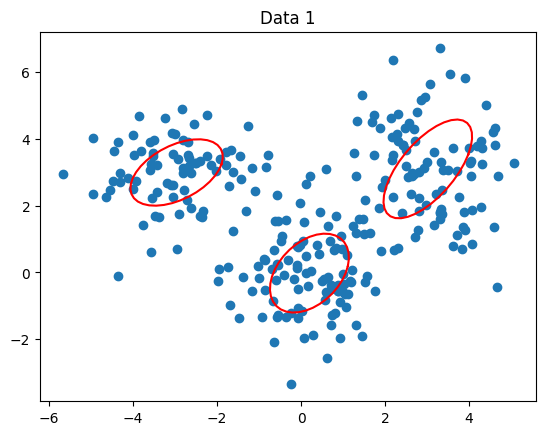

evaluating on dataset 2



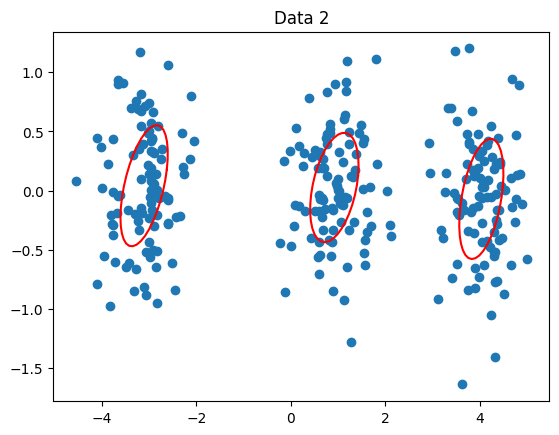

evaluating on dataset 3



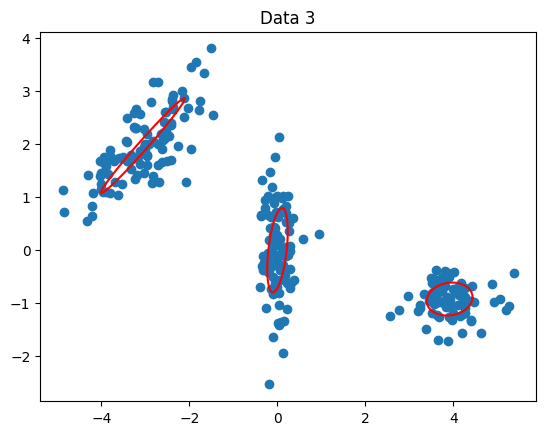

In [79]:
# compute GMM on all 3 datasets
print('\n')
print('(f) evaluating EM for GMM on all datasets')
for idx in range(3):
    print('evaluating on dataset {0}\n'.format(idx+1))

    # compute GMM
    weights, means, covariances = estGaussMixEM(data[idx], K, n_iter, epsilon)

    # plot result
    plt.subplot()
    plotModes(np.transpose(means), covariances, data[idx])
    plt.title('Data {0}'.format(idx+1))
    plt.show()

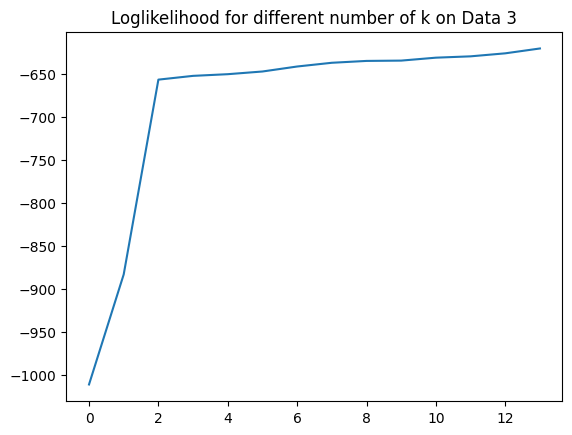

In [80]:
# for different number of modes k plot the log likelihood for data3
num = 14
logLikelihood = np.zeros(num)
for k in range(num):
    # compute GMM
    weights, means, covariances = estGaussMixEM(data[2], k+1, n_iter, epsilon)
    logLikelihood[k] = getLogLikelihood(means, weights, covariances, data[2])

# plot result
plt.subplot()
plt.plot(range(num),logLikelihood)
plt.title('Loglikelihood for different number of k on Data 3')
plt.show()

**Skin Detection (Image Segmentation) using EM**

In [81]:
def skinDetection(ndata, sdata, K, n_iter, epsilon, theta, img):
    # Skin Color detector
    #
    # INPUT:
    # ndata         : data for non-skin color
    # sdata         : data for skin-color
    # K             : number of modes
    # n_iter        : number of iterations
    # epsilon       : regularization parameter
    # theta         : threshold
    # img           : input image
    #
    # OUTPUT:
    # result        : Result of the detector for every image pixel

    height = img.shape[0]
    width = img.shape[1]

    # # GMM for skin pixels
    sk_weights, sk_means, sk_covariances = estGaussMixEM(sdata, K, n_iter, epsilon)

    # # GMM for non-skin pixels
    ns_weights, ns_means, ns_covariances = estGaussMixEM(ndata, K, n_iter, epsilon)

    result = np.zeros((height, width))
    for h in range(height):
        for w in range(width):
            pixel = img[h, w]
            pixel = pixel.reshape(1, len(pixel))
            sk_logLikelihood = np.exp(getLogLikelihood(sk_means, sk_weights, sk_covariances, pixel))
            ns_logLikelihood = np.exp(getLogLikelihood(ns_means, ns_weights, ns_covariances, pixel))

            if sk_logLikelihood / ns_logLikelihood > theta:
                result[h, w] = 1
            else:
                result[h, w] = 0

    return result

In [82]:
print('(g) performing skin detection with GMMs')
sdata = np.loadtxt('/content/skin.dat')
ndata = np.loadtxt('/content/non-skin.dat')

img = img_as_float(imageio.imread('/content/faces.png'))
print(img.shape)

(g) performing skin detection with GMMs
(293, 400, 3)


<ipython-input-82-48fd93033b5a>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = img_as_float(imageio.imread('/content/faces.png'))


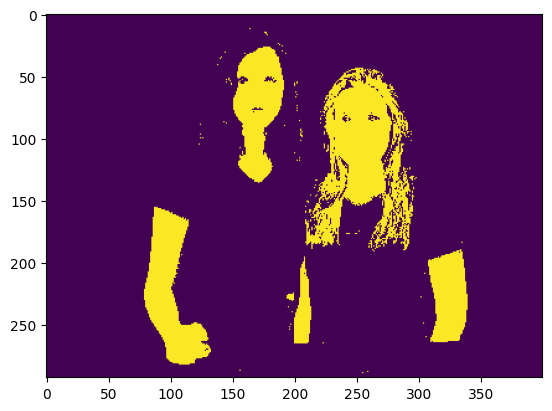

In [83]:
skin = skinDetection(ndata, sdata, skin_K, skin_n_iter, skin_epsilon, theta, img)
plt.imshow(skin)
plt.show()

In [ ]:
# Groundtruth segmentation

img = img_as_float(imageio.imread('/content/faces_groundtruth.png'))
plt.imshow(img)
plt.show()

<ipython-input-84-e0565253aed9>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = img_as_float(imageio.imread('/content/face-2.jpg'))


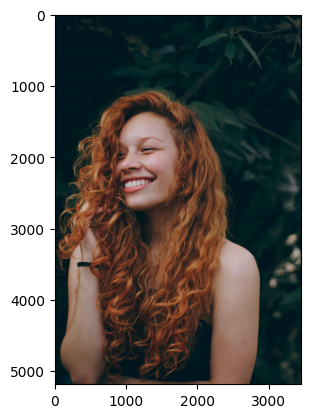

In [84]:
# Trying algorithm on other images

img = img_as_float(imageio.imread('/content/face-2.jpg')) #Image credits: pexels.com
plt.imshow(img)

In [ ]:
# Image is high-resolution, and it may not be a good idea to run this on cpu :(
skin = skinDetection(ndata, sdata, skin_K, skin_n_iter, skin_epsilon, theta, img)
plt.imshow(skin)
plt.show()